# OD Transport data visualisation

In [8]:
# Python equivalents of R spatial and transport analysis libraries

import geopandas as gpd     # Simple Features equivalent - for reading, writing, and manipulating vector spatial data
import shapely              # Geometric operations and spatial data structures
import folium               # Interactive maps - equivalent to tmap for web-based mapping
import matplotlib.pyplot as plt  # Basic plotting functionality
import plotly.express as px # Interactive plotting and mapping
import osmnx as ox          # OpenStreetMap-based transport network analysis - similar to stplanr
import networkx as nx       # Network analysis tools for transport planning
import pandas as pd         # Data manipulation and analysis - core tidyverse equivalent
import numpy as np          # Numerical computing - part of Python data science stack
import contextily as ctx    # Basemap tiles for spatial plots - ggspatial equivalent
import geoplot as gplt      # Statistical plotting with geographic data


In [9]:
# Set interactive mapping mode - Python equivalent of tmap_mode("view")

# For Jupyter notebooks, enable interactive plotting
%matplotlib inline
import plotly.io as pio
pio.renderers.default = "notebook"  # For interactive plotly maps in Jupyter

# Configure folium for interactive maps (tmap equivalent)
# Note: folium maps are interactive by default when displayed in Jupyter
print("Interactive mapping mode enabled - use folium.Map() for interactive maps")


Interactive mapping mode enabled - use folium.Map() for interactive maps


## OD Flow Maps Visualisation

In [10]:
# Load Demand Data - Python equivalent of R code
desire_lines = gpd.read_file("https://github.com/ITSLeeds/TDS/releases/download/22/NTEM_flow.geojson")[
    ['from', 'to', 'all', 'walk', 'drive', 'cycle']
]

print(f"Dimensions: {desire_lines.shape}")
desire_lines.head()


Dimensions: (502, 6)


from         to     all    walk  drive  cycle
0  E02002444  E02002443  1374.0  1121.0   55.0    0.0
1  E02002443  E02002445  1189.0   868.0  100.0    4.0
2  E02002442  E02002440  1494.0  1139.0   83.0   23.0
3  E02002442  E02002441  1747.0   906.0  349.0   62.0
4  E02002447  E02002448  4930.0  4162.0   70.0   98.0

In [18]:
# Let's reload the data properly as GeoDataFrame to preserve geometry
desire_lines = gpd.read_file("https://github.com/ITSLeeds/TDS/releases/download/22/NTEM_flow.geojson")
print("Original columns:", desire_lines.columns.tolist())
print("Data type:", type(desire_lines))
print("Has geometry:", hasattr(desire_lines, 'geometry'))

# Select required columns while preserving geometry
desire_lines = desire_lines[['from', 'to', 'all', 'walk', 'drive', 'cycle', 'geometry']]

# Take top 50 car trips
desire_lines_top = desire_lines.sort_values('drive', ascending=False).head(50)

print(f"\nTop 50 trips - Drive range: {desire_lines_top['drive'].min()} to {desire_lines_top['drive'].max()}")

# Create interactive map with Folium (more reliable in Jupyter)
import folium
from folium import plugins

# Calculate bounds for the map
bounds = desire_lines_top.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Create base map
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Get min/max drive values for color scaling
min_drive = desire_lines_top['drive'].min()
max_drive = desire_lines_top['drive'].max()

print(f"Creating map with {len(desire_lines_top)} desire lines")
print(f"Drive trips range: {min_drive} to {max_drive}")

# Add each desire line to the map
for idx, row in desire_lines_top.iterrows():
    if row.geometry.geom_type == 'LineString':
        # Extract coordinates
        coords = [(coord[1], coord[0]) for coord in row.geometry.coords]  # folium uses (lat, lon)
        
        # Calculate line width based on drive value (scale 2-10)
        line_width = 2 + 8 * (row['drive'] - min_drive) / (max_drive - min_drive)
        
        # Calculate color intensity based on drive value
        color_intensity = (row['drive'] - min_drive) / (max_drive - min_drive)
        if color_intensity < 0.33:
            color = 'orange'
        elif color_intensity < 0.66:
            color = 'red'
        else:
            color = 'darkred'
        
        # Add line to map
        folium.PolyLine(
            locations=coords,
            weight=line_width,
            color=color,
            opacity=0.8,
            popup=f"From: {row['from']}<br>To: {row['to']}<br>Drive trips: {int(row['drive'])}<br>All trips: {int(row['all'])}"
        ).add_to(m)

# Display the map
m


Original columns: ['from', 'to', 'all', 'drive', 'passenger', 'walk', 'cycle', 'rail', 'bus', 'geometry']
Data type: <class 'geopandas.geodataframe.GeoDataFrame'>
Has geometry: True

Top 50 trips - Drive range: 806.0 to 2346.0
Creating map with 50 desire lines
Drive trips range: 806.0 to 2346.0


## Proportional Symbol Flow Maps

In [19]:
# Alternative method: proportional symbols at origin or destination points
# This is useful when you want to quickly see where demand is concentrated

# Summarize total flows by origin - Python equivalent
origin_flows = desire_lines.groupby('from').agg({
    'drive': 'sum',
    'walk': 'sum', 
    'cycle': 'sum',
    'all': 'sum',
    'geometry': lambda x: x.unary_union.centroid  # Get centroid of all geometries from this origin
}).reset_index()

# Calculate percentage drive
origin_flows['total_drive'] = origin_flows['drive']
origin_flows['total_walk'] = origin_flows['walk']
origin_flows['total_cycle'] = origin_flows['cycle']
origin_flows['% drive'] = origin_flows['drive'] / origin_flows['all']

# Convert back to GeoDataFrame
origin_flows = gpd.GeoDataFrame(origin_flows, geometry='geometry')

print(f"Origin flows summary:")
print(f"Number of origins: {len(origin_flows)}")
print(f"Drive trips range: {origin_flows['total_drive'].min():.0f} to {origin_flows['total_drive'].max():.0f}")
print(f"Drive percentage range: {origin_flows['% drive'].min():.2%} to {origin_flows['% drive'].max():.2%}")

origin_flows.head()

Origin flows summary:
Number of origins: 200
Drive trips range: 44 to 24679
Drive percentage range: 1.42% to 60.11%


/tmp/ipykernel_144283/3934007733.py:10: DeprecationWarning:

The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.



from   drive    walk  cycle      all                   geometry  \
0  E02002184   890.0     7.0    4.0   1542.0     POINT (-1.8596 53.898)   
1  E02002185  1145.0  2081.0  137.0   4406.0  POINT (-1.77517 53.91509)   
2  E02002186  6552.0   730.0  223.0  12766.0  POINT (-1.89324 53.89457)   
3  E02002187   684.0    24.0   36.0   1138.0    POINT (-1.7795 53.9092)   
4  E02002188  1583.0  3338.0  118.0   6749.0  POINT (-1.90291 53.88872)   

   total_drive  total_walk  total_cycle   % drive  
0        890.0         7.0          4.0  0.577173  
1       1145.0      2081.0        137.0  0.259873  
2       6552.0       730.0        223.0  0.513238  
3        684.0        24.0         36.0  0.601054  
4       1583.0      3338.0        118.0  0.234553

In [20]:
# Simple map with proportional circles for drive volumes using Folium

# Calculate bounds for the map
bounds = origin_flows.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Create base map
m2 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Get min/max values for scaling
min_drive = origin_flows['total_drive'].min()
max_drive = origin_flows['total_drive'].max()
min_pct = origin_flows['% drive'].min()
max_pct = origin_flows['% drive'].max()

print(f"Creating proportional symbol map with {len(origin_flows)} origins")

# Add proportional circles to the map
for idx, row in origin_flows.iterrows():
    # Extract coordinates (folium uses lat, lon)
    lat = row.geometry.y
    lon = row.geometry.x
    
    # Calculate bubble size (scale 5-50 pixels)
    bubble_size = 5 + 45 * (row['total_drive'] - min_drive) / (max_drive - min_drive)
    
    # Calculate color based on % drive (red intensity)
    drive_pct = row['% drive']
    # Create color from yellow to red based on drive percentage
    if drive_pct < 0.1:  # Less than 10%
        color = '#FFFF99'  # Light yellow
    elif drive_pct < 0.2:  # 10-20%
        color = '#FFD700'  # Gold
    elif drive_pct < 0.3:  # 20-30%
        color = '#FFA500'  # Orange
    elif drive_pct < 0.4:  # 30-40%
        color = '#FF6347'  # Tomato
    else:  # 40%+
        color = '#DC143C'  # Crimson
    
    # Add circle marker
    folium.CircleMarker(
        location=[lat, lon],
        radius=bubble_size,
        popup=f"""
        <b>Origin:</b> {row['from']}<br>
        <b>Total Drive Trips:</b> {int(row['total_drive'])}<br>
        <b>Total Walk Trips:</b> {int(row['total_walk'])}<br>
        <b>Total Cycle Trips:</b> {int(row['total_cycle'])}<br>
        <b>Drive Percentage:</b> {drive_pct:.1%}<br>
        <b>All Trips:</b> {int(row['all'])}
        """,
        color='black',
        fillColor=color,
        fillOpacity=0.7,
        weight=1
    ).add_to(m2)

# Add a legend for the proportional symbols
legend_html = f'''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 140px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:12px; padding: 10px">
<p><b>Proportional Symbol Map - Drive Demand by Origin</b></p>
<p><b>Circle Size:</b> Total Drive Trips</p>
<p>• Small: {int(min_drive)} trips</p>
<p>• Large: {int(max_drive)} trips</p>
<p><b>Color:</b> Drive Percentage</p>
<p><span style="background-color:#FFFF99; padding:2px;">■</span> &lt;10% 
   <span style="background-color:#FFA500; padding:2px;">■</span> 10-30% 
   <span style="background-color:#DC143C; padding:2px;">■</span> &gt;30%</p>
</div>
'''
m2.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m2


Creating proportional symbol map with 200 origins


## Mode-Specific Analysis

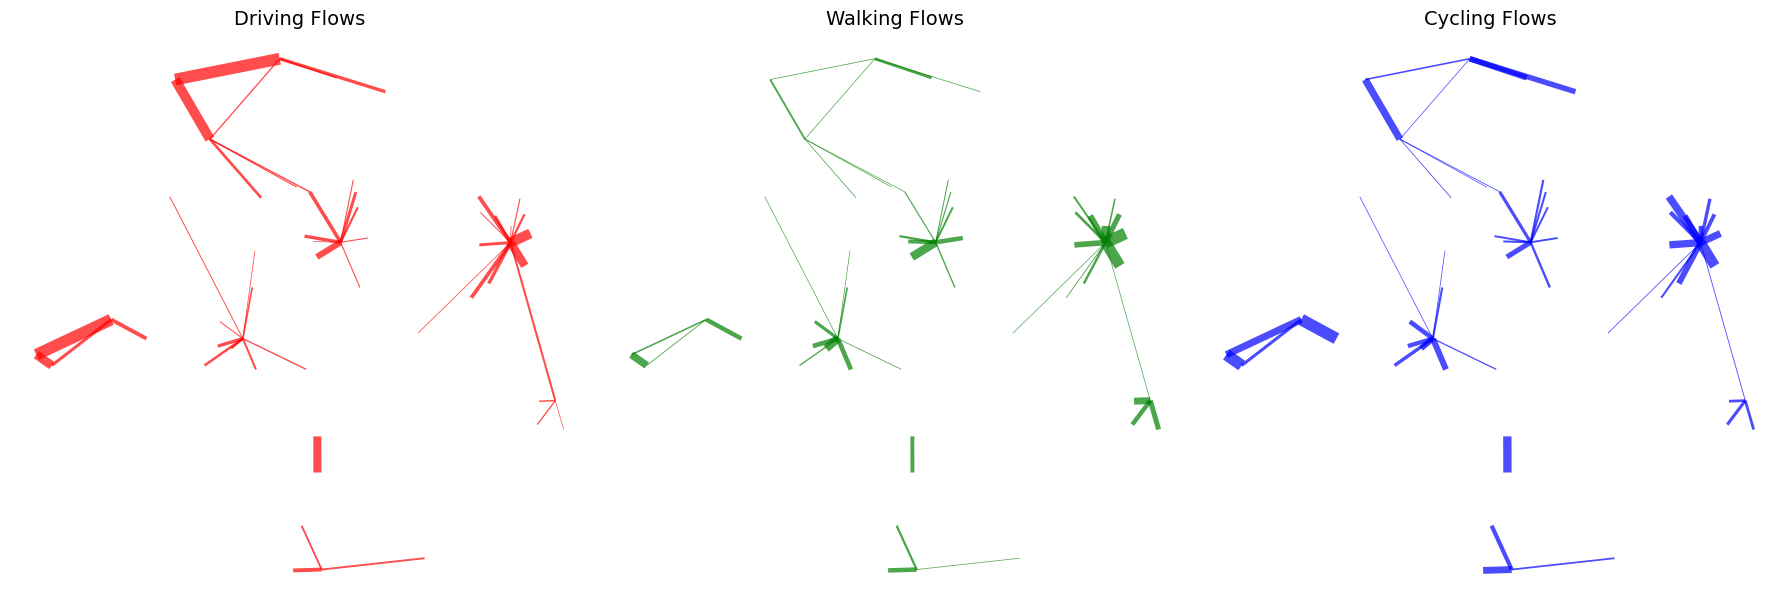

In [22]:
# Create 3 separate maps: drive, walk, cycle with minimum code
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Map configurations
maps = [
    ('drive', 'red', 'Driving Flows'),
    ('walk', 'green', 'Walking Flows'), 
    ('cycle', 'blue', 'Cycling Flows')
]

for i, (mode, color, title) in enumerate(maps):
    # Scale line widths based on mode values
    values = desire_lines_top[mode]
    widths = 0.5 + 8 * (values - values.min()) / (values.max() - values.min())
    
    # Plot each line individually with scaled width
    for j in range(len(desire_lines_top)):
        single_row = desire_lines_top.iloc[[j]]
        single_row.plot(ax=axes[i], linewidth=widths.iloc[j], 
                       color=color, alpha=0.7)
    
    axes[i].set_title(title, fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Analyisng origin-destination data in London Cycle Hire System

In [23]:
# Load bike docking station locations with spatial geometry - Python equivalent
bike_docking_stations = gpd.read_file("https://github.com/itsleeds/tds/releases/download/2025/p3-london-bike_docking_stations.geojson")

# Load trip data as regular CSV (no spatial data, but contains origin/destination IDs)
bike_trips = pd.read_csv("https://github.com/itsleeds/tds/releases/download/2025/p3-london-bike_trips.csv")

print("Bike docking stations:")
print(f"Shape: {bike_docking_stations.shape}")
print(f"Columns: {bike_docking_stations.columns.tolist()}")
print(f"Data type: {type(bike_docking_stations)}")

print("\nBike trips:")
print(f"Shape: {bike_trips.shape}")
print(f"Columns: {bike_trips.columns.tolist()}")
print(f"Data type: {type(bike_trips)}")

# Display first few rows
print("\nFirst 5 docking stations:")
bike_docking_stations.head()


Bike docking stations:
Shape: (820, 3)
Columns: ['station_id', 'station_name', 'geometry']
Data type: <class 'geopandas.geodataframe.GeoDataFrame'>

Bike trips:
Shape: (144048, 4)
Columns: ['start_time', 'stop_time', 'start_station_id', 'end_station_id']
Data type: <class 'pandas.core.frame.DataFrame'>

First 5 docking stations:


station_id                          station_name                   geometry
0         1.0            River Street , Clerkenwell  POINT (-0.10997 51.52916)
1         2.0        Phillimore Gardens, Kensington  POINT (-0.19757 51.49961)
2         3.0  Christopher Street, Liverpool Street  POINT (-0.08461 51.52128)
3         4.0       St. Chad's Street, King's Cross  POINT (-0.12097 51.53006)
4         5.0         Sedding Street, Sloane Square  POINT (-0.15688 51.49313)

In [24]:
# Display first few rows of bike trips data
print("First 5 bike trips:")
bike_trips.head()

First 5 bike trips:


start_time            stop_time  start_station_id  end_station_id
0  2015-07-02 00:00:00  2015-07-02 00:21:00                64             490
1  2015-07-02 00:00:00  2015-07-02 00:11:00                72             439
2  2015-07-02 00:00:00  2015-07-02 00:10:00                87             717
3  2015-07-02 00:00:00  2015-07-02 00:15:00               406             395
4  2015-07-02 00:00:00  2015-07-02 00:24:00               333             103

In [25]:
# Process trip data to identify strike vs non-strike days - Python equivalent
import seaborn as sns
from datetime import datetime

# Extract date from start_time and create type_day column
bike_trips['start_time'] = pd.to_datetime(bike_trips['start_time'])
bike_trips['date'] = bike_trips['start_time'].dt.date

# Create type_day column using numpy.where (equivalent to case_when)
bike_trips['type_day'] = np.where(
    bike_trips['date'] == pd.to_datetime('2015-07-09').date(),
    'Strike Day',
    'Non-Strike Day'
)

# Check the data processing
print("Unique dates in dataset:")
print(bike_trips['date'].value_counts().sort_index())
print("\nDay type distribution:")
print(bike_trips['type_day'].value_counts())


Unique dates in dataset:
date
2015-07-02    36596
2015-07-09    69931
2015-07-16    37521
Name: count, dtype: int64

Day type distribution:
type_day
Non-Strike Day    74117
Strike Day        69931
Name: count, dtype: int64


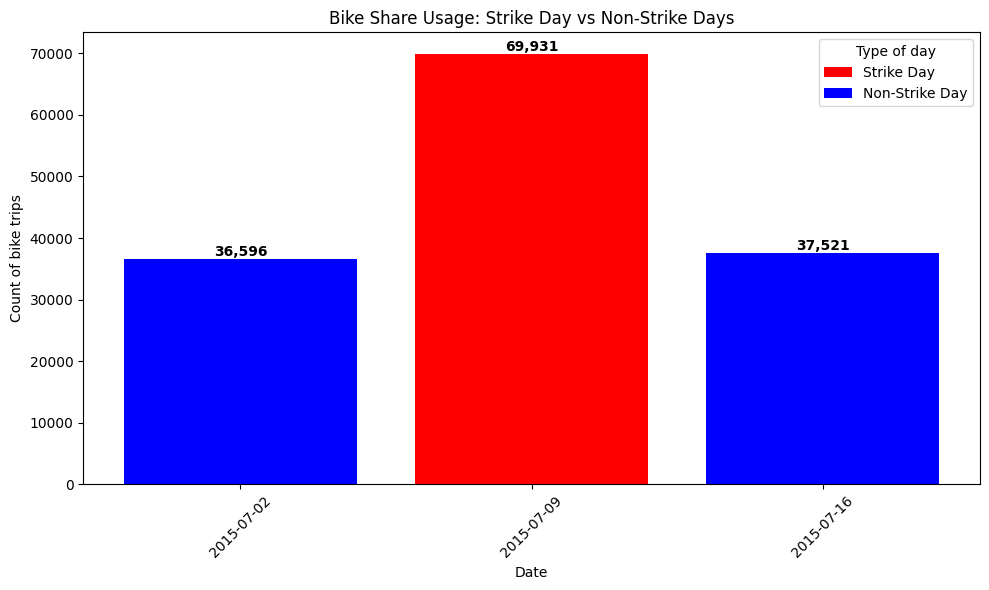


Trip count summary:
2015-07-02 (Non-Strike Day): 36,596 trips
2015-07-09 (Strike Day): 69,931 trips
2015-07-16 (Non-Strike Day): 37,521 trips


In [26]:
# Create bar chart comparing trip counts on different days - Python equivalent

# Group by date and type_day, then count trips
trip_summary = bike_trips.groupby(['date', 'type_day']).size().reset_index(name='count')

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(trip_summary)), trip_summary['count'], 
               color=['red' if day_type == 'Strike Day' else 'blue' 
                     for day_type in trip_summary['type_day']])

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Count of bike trips')
plt.title('Bike Share Usage: Strike Day vs Non-Strike Days')

# Set x-axis labels
plt.xticks(range(len(trip_summary)), 
           [str(date) for date in trip_summary['date']], 
           rotation=45)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Strike Day'),
                   Patch(facecolor='blue', label='Non-Strike Day')]
plt.legend(handles=legend_elements, title='Type of day')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, trip_summary['count'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTrip count summary:")
for i, row in trip_summary.iterrows():
    print(f"{row['date']} ({row['type_day']}): {row['count']:,} trips")


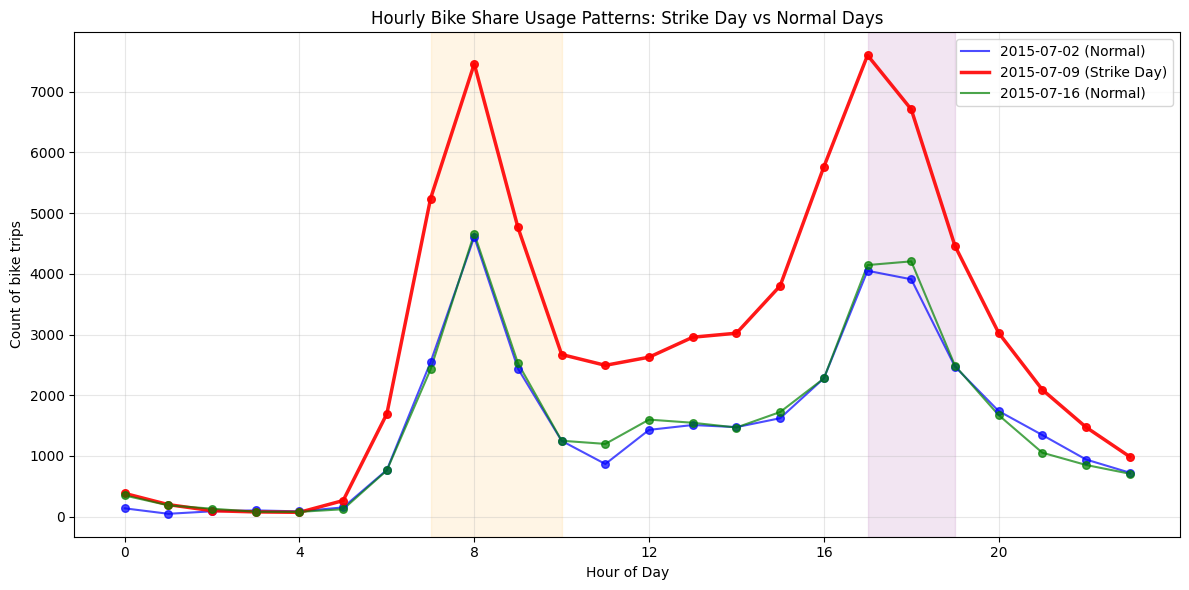

Peak hour analysis:

Morning rush (7-9 AM):
2015-07-02 (Normal Day): 9,589 trips
2015-07-09 (Strike Day): 17,459 trips
2015-07-16 (Normal Day): 9,616 trips

Evening rush (5-7 PM):
2015-07-02 (Normal Day): 10,432 trips
2015-07-09 (Strike Day): 18,767 trips
2015-07-16 (Normal Day): 10,837 trips


In [27]:
# Analyse hourly patterns across the three days - Python equivalent

# Extract hour from start_time and prepare data
bike_trips['hour'] = bike_trips['start_time'].dt.hour

# Group by date and hour, then count trips
hourly_patterns = bike_trips.groupby(['date', 'hour']).size().reset_index(name='count')

# Create the line plot
plt.figure(figsize=(12, 6))

# Get unique dates and assign colors
dates = hourly_patterns['date'].unique()
colors = ['blue', 'red', 'green']  # Blue for July 2, Red for July 9 (strike), Green for July 16

# Plot lines for each date
for i, date in enumerate(sorted(dates)):
    date_data = hourly_patterns[hourly_patterns['date'] == date]
    
    # Determine if this is strike day for styling
    is_strike_day = date == pd.to_datetime('2015-07-09').date()
    color = 'red' if is_strike_day else colors[i]
    linewidth = 2.5 if is_strike_day else 1.5
    alpha = 0.9 if is_strike_day else 0.7
    
    # Plot line and points
    plt.plot(date_data['hour'], date_data['count'], 
             color=color, linewidth=linewidth, alpha=alpha, 
             label=f"{date} {'(Strike Day)' if is_strike_day else '(Normal)'}")
    plt.scatter(date_data['hour'], date_data['count'], 
                color=color, s=30, alpha=alpha, zorder=5)

# Customize the plot
plt.xlabel('Hour of Day')
plt.ylabel('Count of bike trips')
plt.title('Hourly Bike Share Usage Patterns: Strike Day vs Normal Days')
plt.xticks(range(0, 24, 4))  # Show every 4th hour
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations for peak hours
plt.axvspan(7, 10, alpha=0.1, color='orange', label='Morning Rush')
plt.axvspan(17, 19, alpha=0.1, color='purple', label='Evening Rush')

plt.tight_layout()
plt.show()

# Print summary statistics for peak hours
print("Peak hour analysis:")
morning_rush = hourly_patterns[hourly_patterns['hour'].between(7, 9)]
evening_rush = hourly_patterns[hourly_patterns['hour'].between(17, 19)]

print("\nMorning rush (7-9 AM):")
for date in sorted(dates):
    morning_trips = morning_rush[morning_rush['date'] == date]['count'].sum()
    day_type = "Strike Day" if date == pd.to_datetime('2015-07-09').date() else "Normal Day"
    print(f"{date} ({day_type}): {morning_trips:,} trips")

print("\nEvening rush (5-7 PM):")
for date in sorted(dates):
    evening_trips = evening_rush[evening_rush['date'] == date]['count'].sum()
    day_type = "Strike Day" if date == pd.to_datetime('2015-07-09').date() else "Normal Day"
    print(f"{date} ({day_type}): {evening_trips:,} trips")


In [28]:
# 1. Calculate trip frequencies for each O-D pair on strike day
od_strike = bike_trips[bike_trips['type_day'] == 'Strike Day'].groupby(
    ['start_station_id', 'end_station_id']
).size().reset_index(name='count_strike')

print("Strike day O-D pairs:")
print(f"Shape: {od_strike.shape}")
print(f"Total trips: {od_strike['count_strike'].sum():,}")

# 2. Calculate average trip frequencies for each O-D pair on non-strike days
od_non_strike = bike_trips[bike_trips['type_day'] == 'Non-Strike Day'].groupby(
    ['start_station_id', 'end_station_id']
).size().reset_index(name='count_non_strike')

# Divide by 2 since we have 2 non-strike days to get average
od_non_strike['count_non_strike'] = od_non_strike['count_non_strike'] / 2

print("\nNon-strike days O-D pairs:")
print(f"Shape: {od_non_strike.shape}")
print(f"Average total trips per day: {od_non_strike['count_non_strike'].sum():,.1f}")

od_strike.head()


Strike day O-D pairs:
Shape: (50587, 3)
Total trips: 69,931

Non-strike days O-D pairs:
Shape: (46942, 3)
Average total trips per day: 37,058.5


start_station_id  end_station_id  count_strike
0                 1               1             1
1                 1              18             1
2                 1              23             1
3                 1              41             1
4                 1              75             1

In [29]:
# Join the two dataframes to compare strike vs non-strike patterns
od_change = pd.merge(od_strike, od_non_strike, 
                     on=['start_station_id', 'end_station_id'], 
                     how='outer')  # Full join equivalent

# Replace NaN with 0 (equivalent to replace_na)
od_change['count_strike'] = od_change['count_strike'].fillna(0)
od_change['count_non_strike'] = od_change['count_non_strike'].fillna(0)

# Calculate the change in trip count and remove self-loop trips
od_change = od_change[od_change['start_station_id'] != od_change['end_station_id']]  # Remove trips from station to itself
od_change['count_change'] = od_change['count_strike'] - od_change['count_non_strike']  # Calculate difference
od_change = od_change.sort_values('count_change', ascending=False)  # Sort by largest increases first

print("Origin-Destination change analysis:")
print(f"Total O-D pairs: {len(od_change):,}")
print(f"Pairs with increases: {(od_change['count_change'] > 0).sum():,}")
print(f"Pairs with decreases: {(od_change['count_change'] < 0).sum():,}")
print(f"Pairs with no change: {(od_change['count_change'] == 0).sum():,}")

print("\nTop 10 O-D pairs with largest increases:")
od_change.head(10)


Origin-Destination change analysis:
Total O-D pairs: 81,062
Pairs with increases: 45,737
Pairs with decreases: 32,665
Pairs with no change: 2,660

Top 10 O-D pairs with largest increases:


start_station_id  end_station_id  count_strike  count_non_strike  \
1654                 14             109          29.0               5.5   
52867               406             303          36.0              17.0   
7417                 55             109          18.0               1.5   
40780               307             191          35.0              18.5   
54506               427             109          14.0               0.5   
26814               197             194          15.0               2.0   
47651               361             217          13.0               1.0   
20919               154              55          19.0               7.5   
1689                 14             160          11.0               0.0   
26395               194             154          13.0               2.0   

       count_change  
1654           23.5  
52867          19.0  
7417           16.5  
40780          16.5  
54506          13.5  
26814          13.0  
47651          12.0  
20919          11.5  
1689           11.0  
26395          11.0

Bottom 10 O-D pairs with largest decreases:
       start_station_id  end_station_id  count_strike  count_non_strike  \
70652               635             707           0.0               7.5   
52848               406             248           8.0              16.5   
71303               644             707           0.0               8.5   
70701               636             671           0.0              10.0   
33495               248             191           5.0              15.0   
40512               304             406           2.0              12.0   
73436               671             729           1.0              11.5   
25703               191             303          10.0              20.5   
76121               707             644           0.0              13.0   
77641               729             671           0.0              14.5   

       count_change  
70652          -7.5  
52848          -8.5  
71303          -8.5  
70701         -10.0  
33495         -10.0 

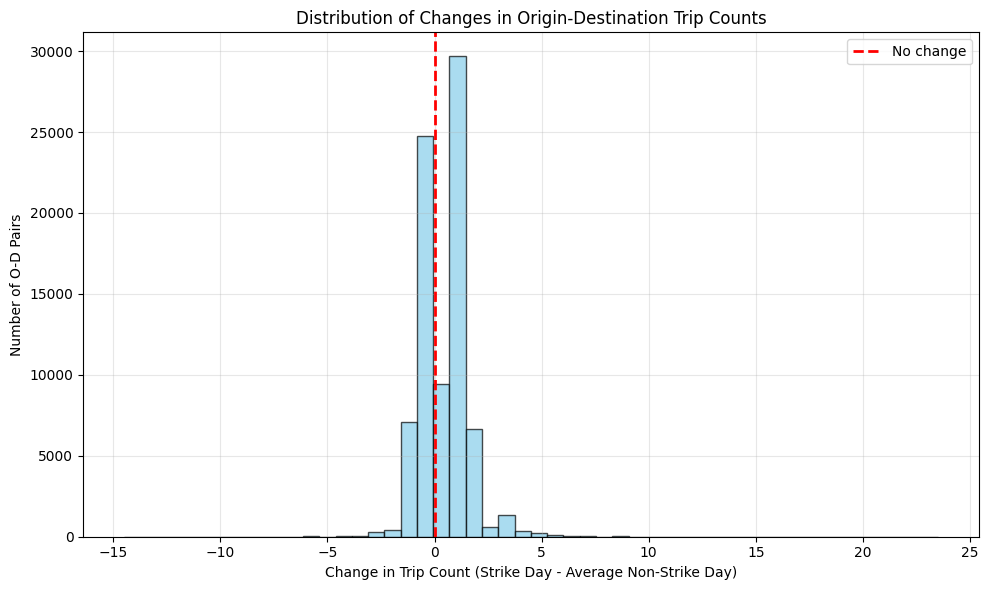

In [30]:
# Let's also look at the biggest decreases and some summary statistics
print("Bottom 10 O-D pairs with largest decreases:")
print(od_change.tail(10))

print(f"\nSummary statistics for count changes:")
print(f"Mean change: {od_change['count_change'].mean():.2f}")
print(f"Median change: {od_change['count_change'].median():.2f}")
print(f"Standard deviation: {od_change['count_change'].std():.2f}")
print(f"Maximum increase: {od_change['count_change'].max():.1f}")
print(f"Maximum decrease: {od_change['count_change'].min():.1f}")

# Create a histogram of changes
plt.figure(figsize=(10, 6))
plt.hist(od_change['count_change'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='No change')
plt.xlabel('Change in Trip Count (Strike Day - Average Non-Strike Day)')
plt.ylabel('Number of O-D Pairs')
plt.title('Distribution of Changes in Origin-Destination Trip Counts')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [32]:
# Focus on inter-station trips (already done, but let's confirm)
od_inter_change = od_change[od_change['start_station_id'] != od_change['end_station_id']].copy()
od_inter_change = od_inter_change.sort_values('count_change', ascending=False)

print(f"Inter-station O-D pairs: {len(od_inter_change):,}")

# First, let's check the column names in bike_docking_stations to fix the KeyError
print("\nBike docking stations columns:", bike_docking_stations.columns.tolist())
print("Sample data:")
print(bike_docking_stations.head(3))

# Create spatial lines connecting origin-destination pairs
# Python equivalent of od2line() function from stplanr package
from shapely.geometry import LineString

def create_desire_lines(od_data, stations_gdf):
    """
    Create desire lines from origin-destination data and station locations
    Python equivalent of stplanr::od2line()
    """
    # Find the correct ID column name
    id_columns = [col for col in stations_gdf.columns if 'id' in col.lower()]
    
    # Use the most likely ID column
    if 'id' in stations_gdf.columns:
        id_col = 'id'
    elif id_columns:
        id_col = id_columns[0]
    else:
        # Look for common station ID column names
        possible_names = ['station_id', 'Id', 'ID', 'terminal', 'name']
        for name in possible_names:
            if name in stations_gdf.columns:
                id_col = name
                break
        else:
            id_col = stations_gdf.columns[0]  # Use first column as fallback
    
    print(f"Using column '{id_col}' as station ID")
    
    # Create dictionaries for quick station lookup
    station_coords = {}
    for idx, station in stations_gdf.iterrows():
        station_coords[station[id_col]] = (station.geometry.x, station.geometry.y)
    
    # Create desire lines
    desire_lines = []
    valid_rows = []
    
    for idx, row in od_data.iterrows():
        start_id = row['start_station_id']
        end_id = row['end_station_id']
        
        # Check if both stations exist in our stations dataset
        if start_id in station_coords and end_id in station_coords:
            start_coord = station_coords[start_id]
            end_coord = station_coords[end_id]
            
            # Create LineString geometry
            line = LineString([start_coord, end_coord])
            desire_lines.append(line)
            valid_rows.append(row)
    
    # Create GeoDataFrame with desire lines
    if valid_rows:
        result_gdf = gpd.GeoDataFrame(valid_rows, geometry=desire_lines)
        return result_gdf
    else:
        return gpd.GeoDataFrame()

# Create desire lines for the changes
print("Creating desire lines...")
change_desire_lines = create_desire_lines(od_inter_change, bike_docking_stations)

print(f"Successfully created {len(change_desire_lines):,} desire lines")
print(f"Change range: {change_desire_lines['count_change'].min():.1f} to {change_desire_lines['count_change'].max():.1f}")

change_desire_lines.head()


Inter-station O-D pairs: 81,062

Bike docking stations columns: ['station_id', 'station_name', 'geometry']
Sample data:
   station_id                          station_name                   geometry
0         1.0            River Street , Clerkenwell  POINT (-0.10997 51.52916)
1         2.0        Phillimore Gardens, Kensington  POINT (-0.19757 51.49961)
2         3.0  Christopher Street, Liverpool Street  POINT (-0.08461 51.52128)
Creating desire lines...
Using column 'station_id' as station ID
Successfully created 81,062 desire lines
Change range: -14.5 to 23.5


start_station_id  end_station_id  count_strike  count_non_strike  \
1654               14.0           109.0          29.0               5.5   
52867             406.0           303.0          36.0              17.0   
7417               55.0           109.0          18.0               1.5   
40780             307.0           191.0          35.0              18.5   
54506             427.0           109.0          14.0               0.5   

       count_change                                           geometry  
1654           23.5  LINESTRING (-0.12362 51.52994, -0.13233 51.51563)  
52867          19.0  LINESTRING (-0.16078 51.51222, -0.15846 51.50295)  
7417           16.5  LINESTRING (-0.08669 51.51708, -0.13233 51.51563)  
40780          16.5  LINESTRING (-0.18784 51.50991, -0.15352 51.50312)  
54506          13.5  LINESTRING (-0.09294 51.51397, -0.13233 51.51563)

O-D pairs with increases ≥1 trip: 38,989
Increase range: 1.0 to 23.5


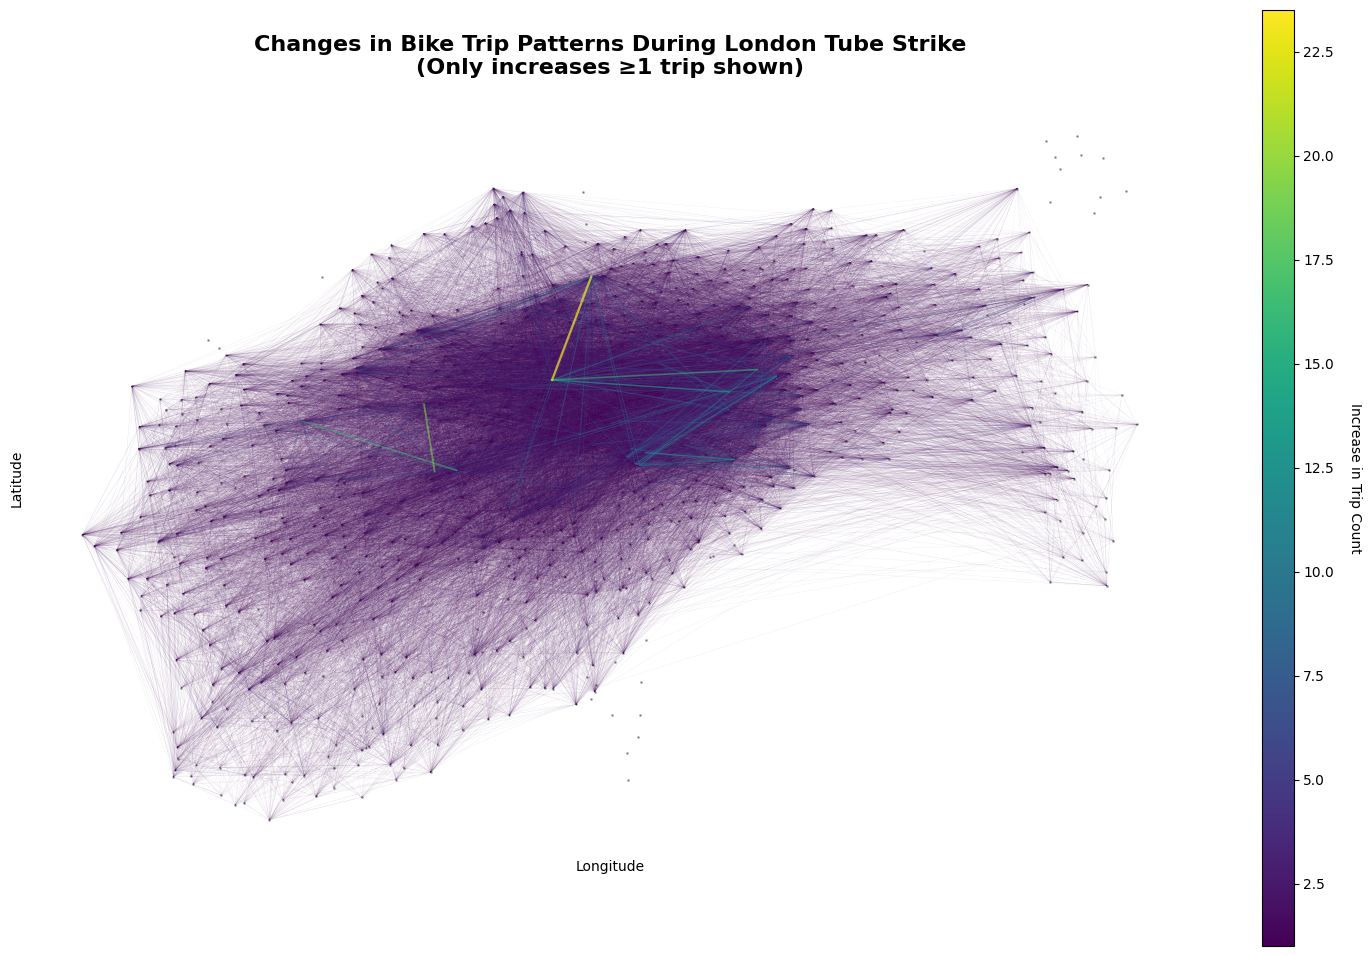


Summary of increases:
Total new trips during strike: 51507
Average increase per route: 1.3
Routes with 5+ trip increases: 315


In [33]:
# Filter to show only O-D pairs that increased during the strike
change_to_plot = change_desire_lines[change_desire_lines['count_change'] >= 1].copy()
change_to_plot = change_to_plot.sort_values('count_change', ascending=True)  # Sort from small to largest increase

print(f"O-D pairs with increases ≥1 trip: {len(change_to_plot):,}")
print(f"Increase range: {change_to_plot['count_change'].min():.1f} to {change_to_plot['count_change'].max():.1f}")

# Create a map showing changes in bike trip patterns during the strike
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the desire lines with color, alpha, and width based on count_change
# Normalize values for better visualization
min_change = change_to_plot['count_change'].min()
max_change = change_to_plot['count_change'].max()

# Create color map (viridis equivalent)
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize values for color mapping
norm = mcolors.Normalize(vmin=min_change, vmax=max_change)
colormap = cm.viridis

for idx, row in change_to_plot.iterrows():
    change_val = row['count_change']
    
    # Calculate line properties based on change value
    color = colormap(norm(change_val))
    alpha = 0.1 + 0.6 * (change_val - min_change) / (max_change - min_change)  # 0.1 to 0.7
    linewidth = 0.2 + 1.4 * (change_val - min_change) / (max_change - min_change)  # 0.2 to 1.6
    
    # Extract coordinates and plot line
    coords = list(row.geometry.coords)
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    
    ax.plot(x_coords, y_coords, color=color, alpha=alpha, linewidth=linewidth)

# Add station points for context
bike_docking_stations.plot(ax=ax, color='black', markersize=1, alpha=0.3)

# Customize the plot
ax.set_title('Changes in Bike Trip Patterns During London Tube Strike\n(Only increases ≥1 trip shown)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, alpha=0.3)

# Add colorbar
sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8, aspect=30)
cbar.set_label('Increase in Trip Count', rotation=270, labelpad=20)

# Remove axis for cleaner look (equivalent to theme_void)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary of increases
print(f"\nSummary of increases:")
print(f"Total new trips during strike: {change_to_plot['count_change'].sum():.0f}")
print(f"Average increase per route: {change_to_plot['count_change'].mean():.1f}")
print(f"Routes with 5+ trip increases: {(change_to_plot['count_change'] >= 5).sum()}")


Rivers data:
Shape: (3, 1)
Geometry type: GeometryCollection    3
Name: count, dtype: int64
Bounds: [-2.39107528e-01  5.14638978e+01  2.16597328e-04  5.15099094e+01]

Parks data:
Shape: (288, 11)
Geometry type: MultiPolygon    288
Name: count, dtype: int64
Bounds: [-2.39107528e-01  5.14496380e+01  2.16597314e-04  5.15509800e+01]


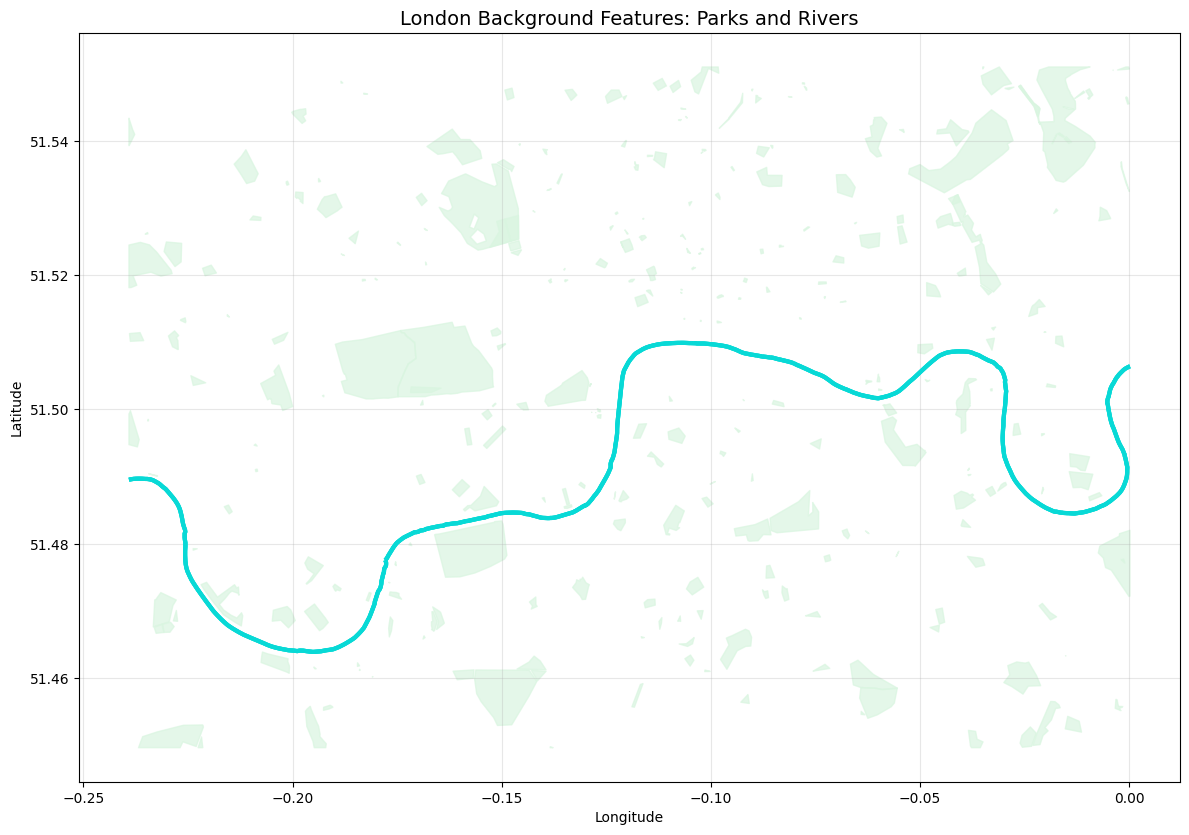

In [34]:
# Load background geographic features for context
rivers = gpd.read_file("https://github.com/itsleeds/tds/releases/download/2025/p3-london-rivers.geojson")
parks = gpd.read_file("https://github.com/itsleeds/tds/releases/download/2025/p3-london-parks.geojson")

print("Rivers data:")
print(f"Shape: {rivers.shape}")
print(f"Geometry type: {rivers.geom_type.value_counts()}")
print(f"Bounds: {rivers.total_bounds}")

print("\nParks data:")
print(f"Shape: {parks.shape}")
print(f"Geometry type: {parks.geom_type.value_counts()}")
print(f"Bounds: {parks.total_bounds}")

# Preview the background features
fig, ax = plt.subplots(figsize=(12, 10))

# Plot parks as light green areas and rivers as cyan lines
parks.plot(ax=ax, color="#d9f5e0", edgecolor="#d9f5e0", alpha=0.7)  # Light green for parks
rivers.plot(ax=ax, color="#08D9D6", linewidth=3)  # Cyan for River Thames

ax.set_title("London Background Features: Parks and Rivers", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Plotted 38,989 desire lines showing trip increases


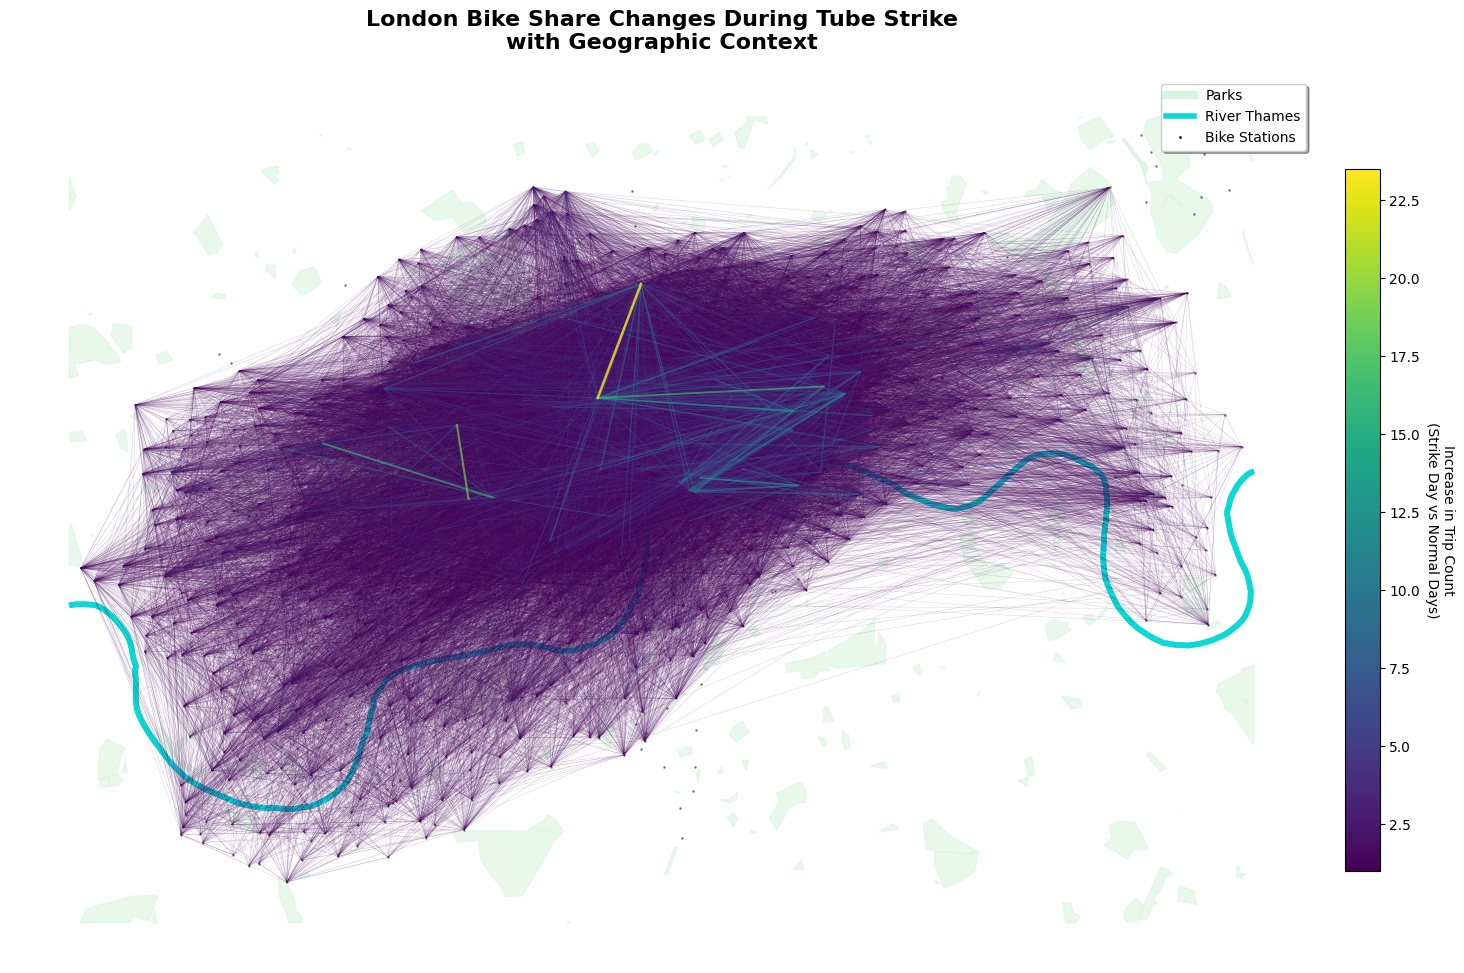


Spatial Analysis Summary:
• Parks: 288 green spaces providing geographic context
• Rivers: 3 water features (mainly River Thames)
• Bike stations: 820 docking locations
• Significant route changes: 38989 O-D pairs with ≥1 trip increase
• Total additional trips during strike: 51507


In [35]:
# Create comprehensive map with background context and O-D flows
fig, ax = plt.subplots(figsize=(16, 12))

# Add background features first (they appear behind other layers)
parks.plot(ax=ax, color="#d9f5e0", edgecolor="#d9f5e0", alpha=0.6, label="Parks")  # Parks as light green areas
rivers.plot(ax=ax, color="#08D9D6", linewidth=4, alpha=0.8, label="River Thames")  # River Thames in cyan

# Check if we have the change_to_plot data from previous analysis
if 'change_to_plot' in locals() and len(change_to_plot) > 0:
    # Add the desire lines showing changes in bike trips
    min_change = change_to_plot['count_change'].min()
    max_change = change_to_plot['count_change'].max()
    
    # Create color map (viridis equivalent)
    norm = mcolors.Normalize(vmin=min_change, vmax=max_change)
    colormap = cm.viridis
    
    for idx, row in change_to_plot.iterrows():
        change_val = row['count_change']
        
        # Calculate line properties based on change value
        color = colormap(norm(change_val))
        alpha = 0.2 + 0.6 * (change_val - min_change) / (max_change - min_change)  # 0.2 to 0.8
        linewidth = 0.3 + 1.5 * (change_val - min_change) / (max_change - min_change)  # 0.3 to 1.8
        
        # Extract coordinates and plot line
        coords = list(row.geometry.coords)
        x_coords = [coord[0] for coord in coords]
        y_coords = [coord[1] for coord in coords]
        
        ax.plot(x_coords, y_coords, color=color, alpha=alpha, linewidth=linewidth)
    
    # Add colorbar for desire lines
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6, aspect=20, pad=0.02)
    cbar.set_label('Increase in Trip Count\n(Strike Day vs Normal Days)', rotation=270, labelpad=25)
    
    print(f"Plotted {len(change_to_plot):,} desire lines showing trip increases")
else:
    print("Note: change_to_plot data not available. Run previous cells first.")

# Add station points for reference
bike_docking_stations.plot(ax=ax, color='black', markersize=0.8, alpha=0.4, label="Bike Stations")

# Customize the plot
ax.set_title('London Bike Share Changes During Tube Strike\nwith Geographic Context', 
             fontsize=16, fontweight='bold', pad=20)

# Add legend for background features
legend_elements = [
    plt.Line2D([0], [0], color="#d9f5e0", linewidth=6, label="Parks"),
    plt.Line2D([0], [0], color="#08D9D6", linewidth=4, label="River Thames"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', 
               markersize=3, label="Bike Stations", linestyle='None')
]
ax.legend(handles=legend_elements, loc='upper right', fancybox=True, shadow=True)

# Clean styling
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# Print analysis summary
if 'change_to_plot' in locals():
    print(f"\nSpatial Analysis Summary:")
    print(f"• Parks: {len(parks)} green spaces providing geographic context")
    print(f"• Rivers: {len(rivers)} water features (mainly River Thames)")
    print(f"• Bike stations: {len(bike_docking_stations)} docking locations")
    print(f"• Significant route changes: {len(change_to_plot)} O-D pairs with ≥1 trip increase")
    print(f"• Total additional trips during strike: {change_to_plot['count_change'].sum():.0f}")
else:
    print("Run the previous desire lines analysis to see the complete visualization.")


## Spatial Analyis on bike trip departures

In [36]:
# Load Tube station locations
tube_stations = gpd.read_file("https://github.com/itsleeds/tds/releases/download/2025/p3-london-tube_stations.geojson")

print("Tube stations data:")
print(f"Shape: {tube_stations.shape}")
print(f"Total bounds: {tube_stations.total_bounds}")

# Crop Tube stations to central London area (where bike docking stations are located)
# Python equivalent of st_crop() - clip to bounding box of bike docking stations
bike_bbox = bike_docking_stations.total_bounds
tube_stations_central_london = tube_stations.cx[bike_bbox[0]:bike_bbox[2], bike_bbox[1]:bike_bbox[3]]

print(f"\nTube stations in central London area: {len(tube_stations_central_london)}")

# Display first few tube stations
tube_stations_central_london.head()


Tube stations data:
Shape: (303, 3)
Total bounds: [-0.61099999 51.40219999  0.25100001 51.70519999]

Tube stations in central London area: 142


id          name                 geometry
1   2.0       Aldgate  POINT (-0.0755 51.5143)
2   3.0  Aldgate East  POINT (-0.0726 51.5154)
3   4.0    All Saints   POINT (-0.013 51.5107)
5   7.0         Angel  POINT (-0.1058 51.5322)
9  11.0  Baker Street  POINT (-0.1571 51.5226)

Created 142 individual 250m buffer zones


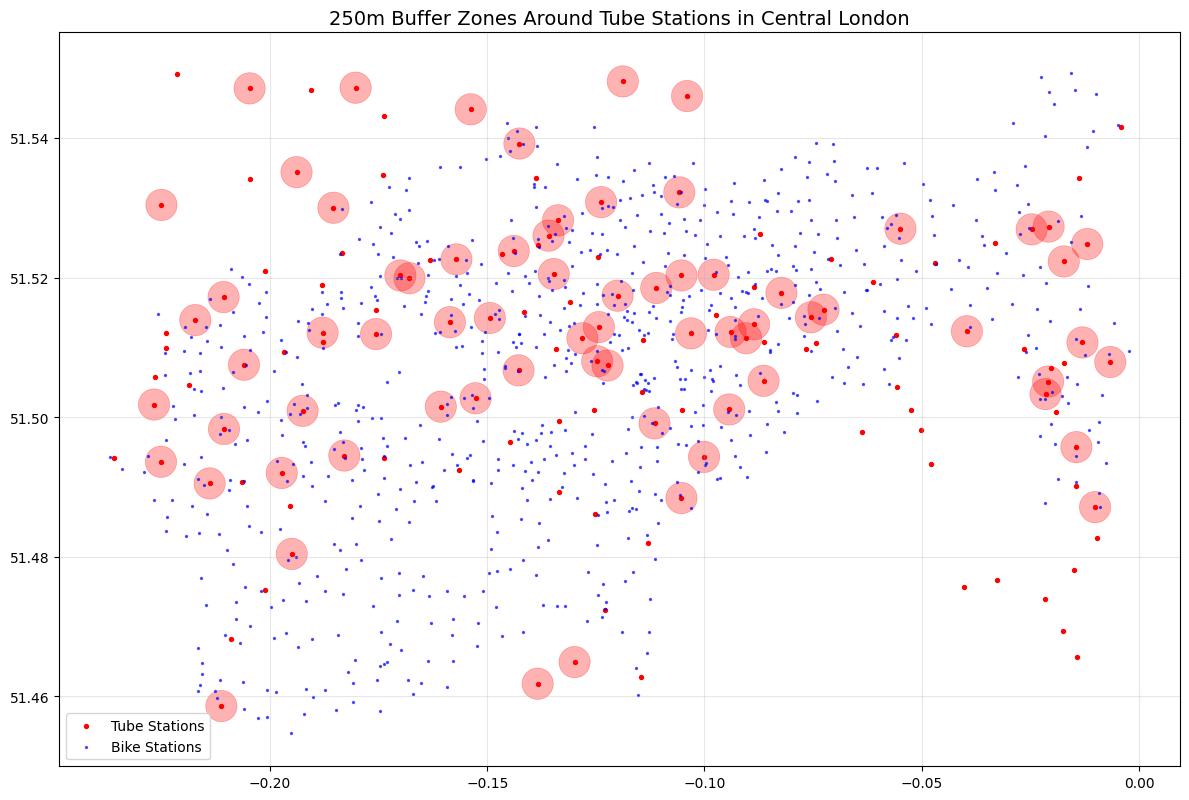

In [37]:
# Create 250m buffer zones around each Tube station
# Convert to British National Grid (EPSG:27700) for accurate distance calculation in meters
tube_stations_central_london_projected = tube_stations_central_london.to_crs('EPSG:27700')

# Create 250m buffer around each tube station
tube_stations_central_london_buffer = tube_stations_central_london_projected.buffer(250)  # 250 meter radius buffer

# Convert back to WGS84 for consistency with other datasets
tube_stations_central_london_buffer = gpd.GeoDataFrame(
    tube_stations_central_london.index, 
    geometry=tube_stations_central_london_buffer.to_crs('EPSG:4326'),
    crs='EPSG:4326'
)

print(f"Created {len(tube_stations_central_london_buffer)} individual 250m buffer zones")

# Visualize individual buffers
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the buffers
tube_stations_central_london_buffer.plot(ax=ax, color='red', alpha=0.3, edgecolor='red', linewidth=0.5)

# Plot tube stations as points
tube_stations_central_london.plot(ax=ax, color='red', markersize=8, label='Tube Stations')

# Plot bike stations for context
bike_docking_stations.plot(ax=ax, color='blue', markersize=2, alpha=0.6, label='Bike Stations')

ax.set_title('250m Buffer Zones Around Tube Stations in Central London', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Buffer merge complete:
Individual buffers: 142
Merged buffer: 1 polygon
Merged buffer geometry type: MultiPolygon


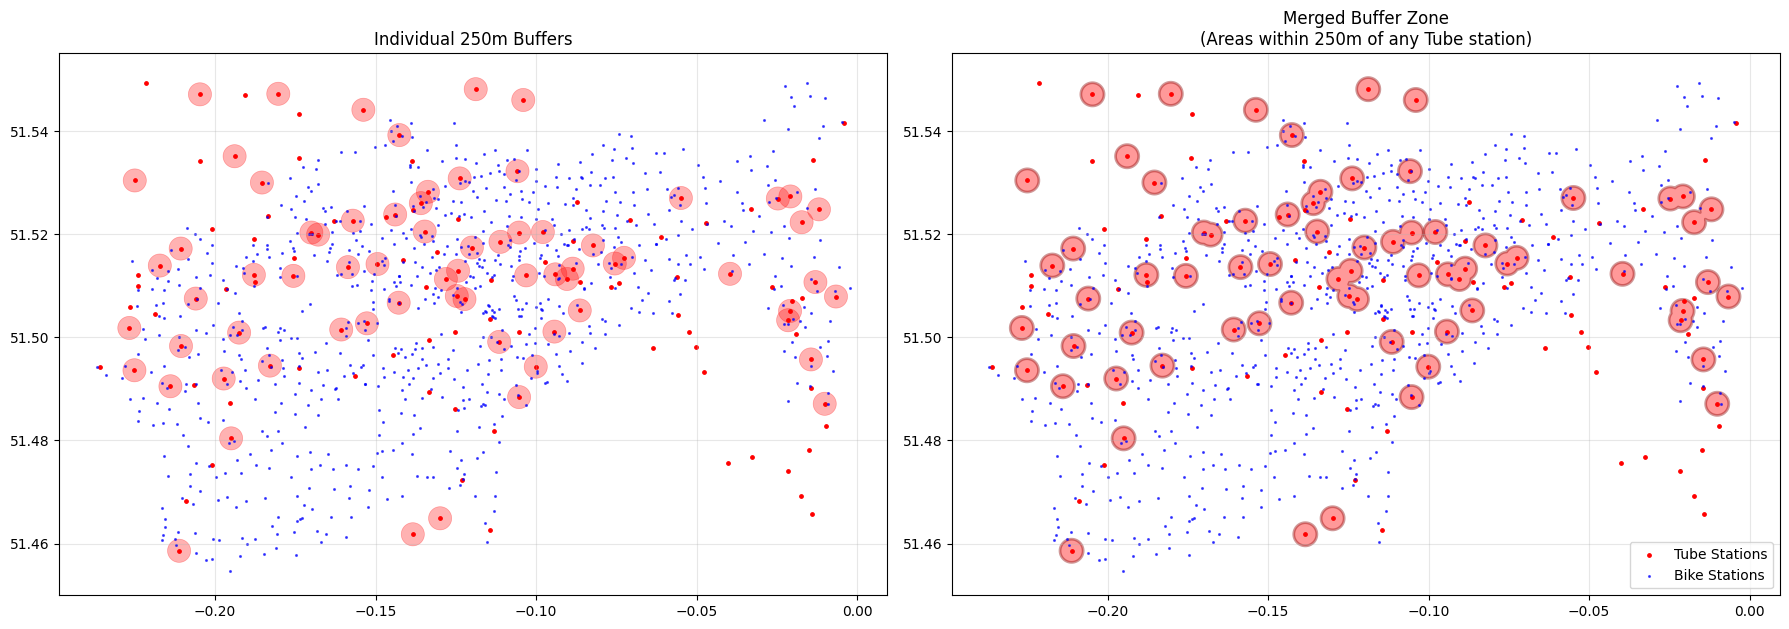


The merged buffer creates a single polygon covering all areas within 250m of any Tube station.
This will be used to classify bike stations as 'near' or 'far' from Tube infrastructure.


In [38]:
# Merge all individual Tube station buffers into one continuous area
# Python equivalent of st_union() - dissolve all buffer geometries into single polygon
from shapely.ops import unary_union

# Merge all buffer geometries into a single geometry
merged_buffer_geometry = unary_union(tube_stations_central_london_buffer.geometry)

# Create a new GeoDataFrame with the merged buffer
tube_stations_central_london_buffer_merged = gpd.GeoDataFrame(
    [0], 
    geometry=[merged_buffer_geometry], 
    crs='EPSG:4326'
)

print("Buffer merge complete:")
print(f"Individual buffers: {len(tube_stations_central_london_buffer)}")
print(f"Merged buffer: {len(tube_stations_central_london_buffer_merged)} polygon")
print(f"Merged buffer geometry type: {merged_buffer_geometry.geom_type}")

# Visualize the merged buffer
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left plot: Individual buffers
tube_stations_central_london_buffer.plot(ax=ax1, color='red', alpha=0.3, edgecolor='red', linewidth=0.5)
tube_stations_central_london.plot(ax=ax1, color='red', markersize=6)
bike_docking_stations.plot(ax=ax1, color='blue', markersize=1.5, alpha=0.6)
ax1.set_title('Individual 250m Buffers', fontsize=12)
ax1.grid(True, alpha=0.3)

# Right plot: Merged buffer
tube_stations_central_london_buffer_merged.plot(ax=ax2, color='red', alpha=0.4, edgecolor='darkred', linewidth=2)
tube_stations_central_london.plot(ax=ax2, color='red', markersize=6, label='Tube Stations')
bike_docking_stations.plot(ax=ax2, color='blue', markersize=1.5, alpha=0.6, label='Bike Stations')
ax2.set_title('Merged Buffer Zone\n(Areas within 250m of any Tube station)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nThe merged buffer creates a single polygon covering all areas within 250m of any Tube station.")
print(f"This will be used to classify bike stations as 'near' or 'far' from Tube infrastructure.")


In [40]:
# First, we need to add buffer status to bike_docking_stations dataset
# Create a copy and add the buffer classification
bike_docking_stations_with_buffer = bike_docking_stations.copy()

# Add buffer status column
bike_docking_stations_with_buffer['inside_tube_buffer'] = False
bike_docking_stations_with_buffer.loc[bike_stations_in_buffer, 'inside_tube_buffer'] = True

print("Buffer status added to bike stations:")
print(bike_docking_stations_with_buffer['inside_tube_buffer'].value_counts())

# Check what column name to use for station ID in bike_docking_stations
print("\nBike docking stations columns:", bike_docking_stations_with_buffer.columns.tolist())
bike_docking_stations_with_buffer.head()


Buffer status added to bike stations:
inside_tube_buffer
False    697
True     123
Name: count, dtype: int64

Bike docking stations columns: ['station_id', 'station_name', 'geometry', 'inside_tube_buffer']


station_id                          station_name  \
0         1.0            River Street , Clerkenwell   
1         2.0        Phillimore Gardens, Kensington   
2         3.0  Christopher Street, Liverpool Street   
3         4.0       St. Chad's Street, King's Cross   
4         5.0         Sedding Street, Sloane Square   

                    geometry  inside_tube_buffer  
0  POINT (-0.10997 51.52916)               False  
1  POINT (-0.19757 51.49961)               False  
2  POINT (-0.08461 51.52128)               False  
3  POINT (-0.12097 51.53006)                True  
4  POINT (-0.15688 51.49313)               False

In [41]:
# Compare trip patterns between bike stations near/far from Tube stations
# Group by station, date, and day type, then count trips
trip_summary_by_station = bike_trips.groupby(['start_station_id', 'date', 'type_day']).size().reset_index(name='count')

print(f"Trip summary by station shape: {trip_summary_by_station.shape}")
print("Sample data:")
print(trip_summary_by_station.head())

# Find the correct ID column name for joining
# Let's check what ID column exists in bike_docking_stations
id_columns = [col for col in bike_docking_stations_with_buffer.columns if 'id' in col.lower()]
print(f"\nAvailable ID columns in bike stations: {id_columns}")

# Use the first ID column found
if id_columns:
    station_id_col = id_columns[0]
else:
    # Look for other common station identifier columns
    possible_names = ['station_id', 'Id', 'ID', 'terminal', 'name']
    for name in possible_names:
        if name in bike_docking_stations_with_buffer.columns:
            station_id_col = name
            break
    else:
        station_id_col = bike_docking_stations_with_buffer.columns[0]

print(f"Using '{station_id_col}' as station ID column for joining")

# Create a version without geometry for faster joining
bike_stations_for_join = bike_docking_stations_with_buffer.drop(columns=['geometry'])

# Join with bike station data to get buffer status
trip_summary_with_buffer = trip_summary_by_station.merge(
    bike_stations_for_join,
    left_on='start_station_id',
    right_on=station_id_col,
    how='left'
)

print(f"\nAfter joining: {trip_summary_with_buffer.shape}")
print("Buffer status distribution in trips:")
print(trip_summary_with_buffer['inside_tube_buffer'].value_counts(dropna=False))


Trip summary by station shape: (2212, 4)
Sample data:
   start_station_id        date        type_day  count
0                 1  2015-07-02  Non-Strike Day     23
1                 1  2015-07-09      Strike Day     42
2                 1  2015-07-16  Non-Strike Day     39
3                 2  2015-07-02  Non-Strike Day     57
4                 2  2015-07-09      Strike Day    110

Available ID columns in bike stations: ['station_id', 'inside_tube_buffer']
Using 'station_id' as station ID column for joining

After joining: (2212, 7)
Buffer status distribution in trips:
inside_tube_buffer
False    1864
True      348
Name: count, dtype: int64


Average trip counts by buffer status and day type:
   inside_tube_buffer        type_day  mean_count
0               False  Non-Strike Day   46.956627
1               False      Strike Day   85.988691
2                True  Non-Strike Day   67.482759
3                True      Strike Day  144.000000


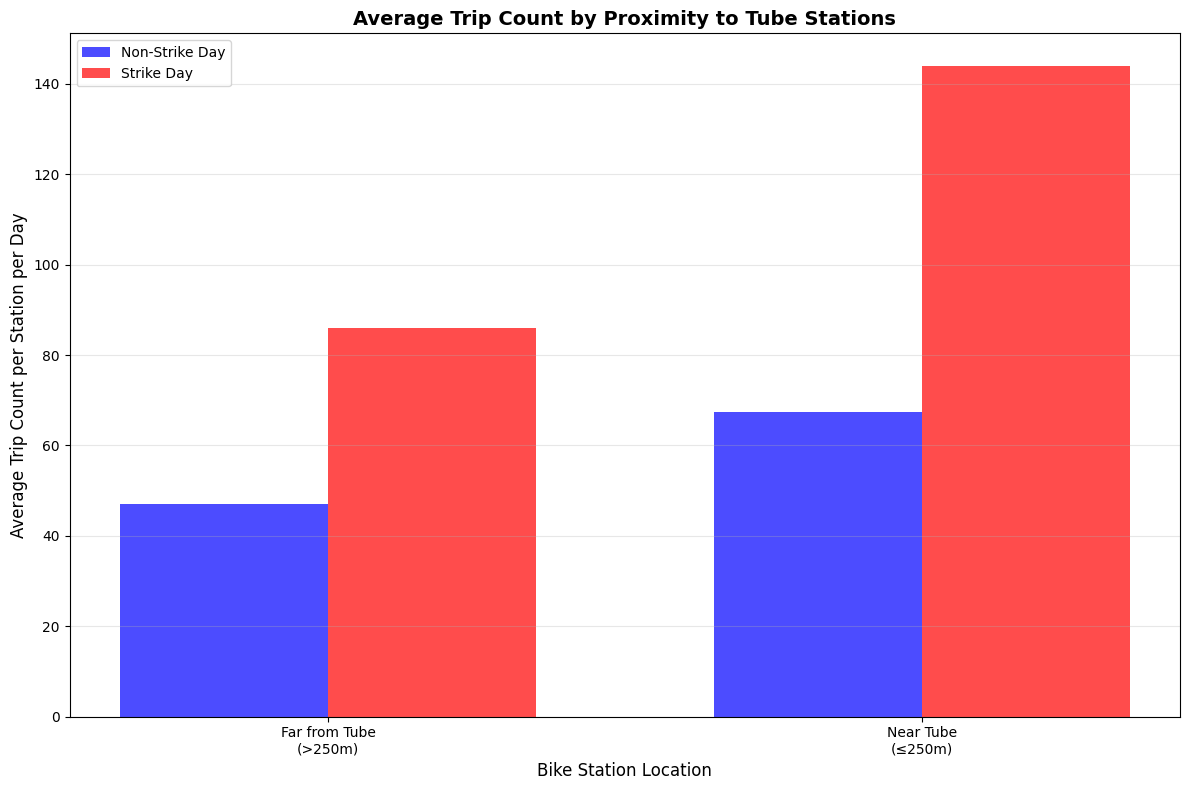

In [42]:
# Calculate average trips by buffer status and day type
trip_summary_clean = trip_summary_with_buffer.dropna(subset=['inside_tube_buffer'])

# Calculate mean trips by buffer status and day type
comparison_summary = trip_summary_clean.groupby(['inside_tube_buffer', 'type_day'])['count'].mean().reset_index()
comparison_summary.columns = ['inside_tube_buffer', 'type_day', 'mean_count']

print("Average trip counts by buffer status and day type:")
print(comparison_summary)

# Create bar chart comparing the groups
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for plotting - create separate datasets for each day type
strike_data = comparison_summary[comparison_summary['type_day'] == 'Strike Day']
non_strike_data = comparison_summary[comparison_summary['type_day'] == 'Non-Strike Day']

# Set up bar positions
x = np.arange(2)  # Two categories: False (outside), True (inside buffer)
width = 0.35

# Extract values for plotting
non_strike_values = [
    non_strike_data[non_strike_data['inside_tube_buffer'] == False]['mean_count'].iloc[0] if len(non_strike_data[non_strike_data['inside_tube_buffer'] == False]) > 0 else 0,
    non_strike_data[non_strike_data['inside_tube_buffer'] == True]['mean_count'].iloc[0] if len(non_strike_data[non_strike_data['inside_tube_buffer'] == True]) > 0 else 0
]

strike_values = [
    strike_data[strike_data['inside_tube_buffer'] == False]['mean_count'].iloc[0] if len(strike_data[strike_data['inside_tube_buffer'] == False]) > 0 else 0,
    strike_data[strike_data['inside_tube_buffer'] == True]['mean_count'].iloc[0] if len(strike_data[strike_data['inside_tube_buffer'] == True]) > 0 else 0
]

# Create bars
bars1 = ax.bar(x - width/2, non_strike_values, width, 
               label='Non-Strike Day', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, strike_values, width,
               label='Strike Day', color='red', alpha=0.7)

# Customize the plot
ax.set_xlabel('Bike Station Location', fontsize=12)
ax.set_ylabel('Average Trip Count per Station per Day', fontsize=12)
ax.set_title('Average Trip Count by Proximity to Tube Stations', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Far from Tube\n(>250m)', 'Near Tube\n(≤250m)'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
